In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
import matplotlib.pyplot as plt
from util import get_stock, bin_data, split_data
import math

In [14]:
def test_stock(stock, bin_size=365):

    # Get the stock data
    df, index = get_stock(stock[1], stock[2], stock[0])

    # Time axis for Gaussian pulses
    t_continuous = np.linspace(1, len(df), num=len(df))
    signal = np.zeros(t_continuous.shape)
    gaussian_basis_sum = np.zeros_like(t_continuous)  # Sum of Gaussians
    
    # Standard deviation for Gaussian pulses
    sigma = 2
    n = len(df)
    t = np.arange(n)  # Creating t as a range based on the array length
    gaussian_matrix = np.zeros((n, len(t_continuous)))
    
    # Sum of Gaussian pulses
    for i in range(n):
        A = df[i]  # Stock price as amplitude
        t0 = float(t[i])  # Ensure t0 is a scalar by casting to float
        
        # Gaussian pulse with amplitude A
        gaussian_pulse = A * np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
        signal += gaussian_pulse
        gaussian_matrix[i, :] = gaussian_pulse
    
        # Gaussian basis with amplitude 1
        gaussian_basis = np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
        gaussian_basis_sum += gaussian_basis
    
    # Avoid dividing by zero by replacing zeros with small values in gaussian_basis_sum
    gaussian_basis_sum[gaussian_basis_sum == 0] = 1e-8
    normalized_signal = signal / gaussian_basis_sum

    # Create bins
    bins = bin_data(df, bin_size)

    # Split the data
    X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

    # Run the linear model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = np.floor(model.predict(X_test))
    y_test = np.floor(y_test)
    
    
    plt.plot(test_index[-100:], y_test[-100:], label="actual")
    plt.plot(test_index[-100:], y_pred[-100:], color="red", label="predictions")
    plt.title("Test data")
    plt.ylabel("Price")
    plt.xlabel("Days")
    plt.legend()
    plt.show()

## Training Examples

In [5]:
# Define the stock and date range
start = '1980-01-01'
end = '2024-08-10'
stock = '^GSPC'
bin_size = 365

df, index = get_stock(start, end, stock)
print(df)

[*********************100%***********************]  1 of 1 completed

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5199.5       ]
 [5319.31005859]
 [5344.16015625]]


# Feature Engineering: Gaussian Pulses Approach

We will turn the financial data into a smooth curve using gaussian distributions to avoid pickup up on noise.

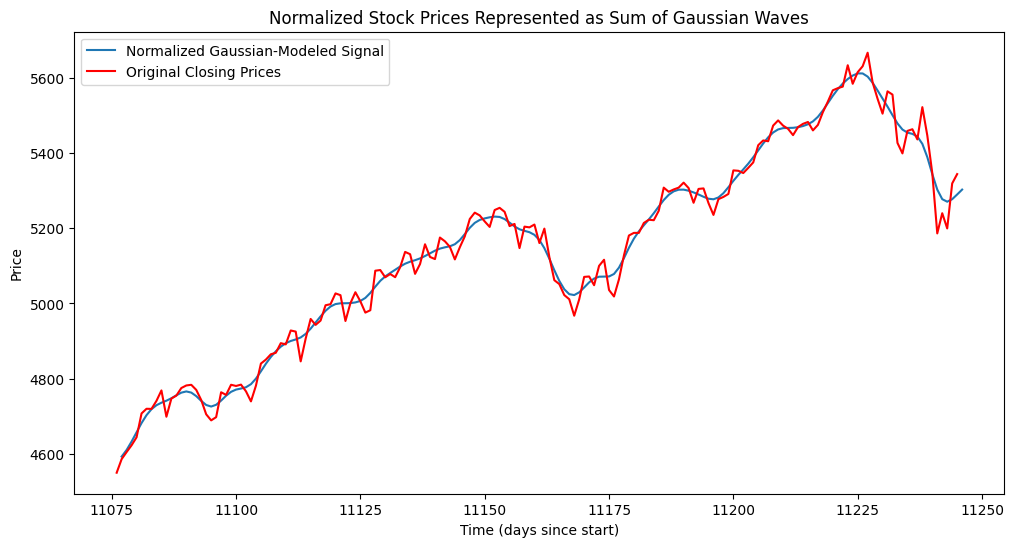

In [6]:
# Time axis for Gaussian pulses
t_continuous = np.linspace(1, len(df), num=len(df))
signal = np.zeros(t_continuous.shape)
gaussian_basis_sum = np.zeros_like(t_continuous)  # Sum of Gaussians

# Standard deviation for Gaussian pulses
sigma = 2
n = len(df)
t = np.arange(n)  # Creating t as a range based on the array length
gaussian_matrix = np.zeros((n, len(t_continuous)))

# Sum of Gaussian pulses
for i in range(n):
    A = df[i]  # Stock price as amplitude
    t0 = float(t[i])  # Ensure t0 is a scalar by casting to float
    
    # Gaussian pulse with amplitude A
    gaussian_pulse = A * np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
    signal += gaussian_pulse
    gaussian_matrix[i, :] = gaussian_pulse

    # Gaussian basis with amplitude 1
    gaussian_basis = np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
    gaussian_basis_sum += gaussian_basis

# Avoid dividing by zero by replacing zeros with small values in gaussian_basis_sum
gaussian_basis_sum[gaussian_basis_sum == 0] = 1e-8
normalized_signal = signal / gaussian_basis_sum

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_continuous[-170:], normalized_signal[-170:], label='Normalized Gaussian-Modeled Signal')
plt.plot(t[-170:], df[-170:], color='red', label='Original Closing Prices')
plt.title('Normalized Stock Prices Represented as Sum of Gaussian Waves')
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.legend()
plt.show()

**Caution: Making sigma higher then 2 causes highly volatile predictions near the end of the stock

## Learning Algorithm

In [7]:
bins = bin_data(normalized_signal)
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# now we make some predictions
y_pred = np.floor(model.predict(X_test))
y_test = np.floor(y_test)
print(y_pred.shape, y_test.shape)

for i in range(math.floor(len(y_pred) * 0.01)):
    print("prediction:", y_pred[i], "| actual:", y_test[i], "| difference:", abs(y_pred[i] - y_test[i]))
# print(y_pred)
print(X_test.shape)

(2176,) (2176,)
prediction: 2051.0 | actual: 2043.0 | difference: 8.0
prediction: 2071.0 | actual: 2073.0 | difference: 2.0
prediction: 2040.0 | actual: 2041.0 | difference: 1.0
prediction: 2008.0 | actual: 2005.0 | difference: 3.0
prediction: 2016.0 | actual: 2021.0 | difference: 5.0
prediction: 2044.0 | actual: 2038.0 | difference: 6.0
prediction: 2056.0 | actual: 2064.0 | difference: 8.0
prediction: 2060.0 | actual: 2060.0 | difference: 0.0
prediction: 2059.0 | actual: 2056.0 | difference: 3.0
prediction: 2071.0 | actual: 2078.0 | difference: 7.0
prediction: 2067.0 | actual: 2063.0 | difference: 4.0
prediction: 2035.0 | actual: 2043.0 | difference: 8.0
prediction: 2020.0 | actual: 2012.0 | difference: 8.0
prediction: 2013.0 | actual: 2016.0 | difference: 3.0
prediction: 1990.0 | actual: 1990.0 | difference: 0.0
prediction: 1939.0 | actual: 1943.0 | difference: 4.0
prediction: 1922.0 | actual: 1922.0 | difference: 0.0
prediction: 1927.0 | actual: 1923.0 | difference: 4.0
prediction: 

(8704,) (2176,)


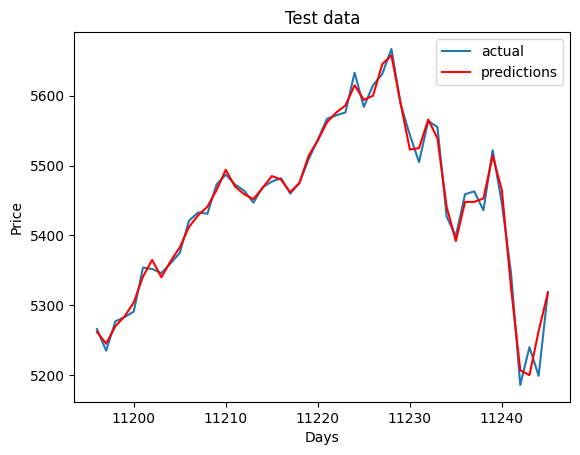

Correctly Classified: 1948/2176
Accuracy: 89.5220588235294%, error_margin of $20
Correctly Classified: 2149/2176
Accuracy: 98.7591911764706%, error_margin of $50


In [10]:
print(train_index.shape, test_index.shape)
plt.plot(test_index[-50:], y_test[-50:], label="actual")
plt.plot(test_index[-50:], y_pred[-50:], color="red", label="predictions")
plt.title("Test data")
plt.ylabel("Price")
plt.xlabel("Days")
plt.legend()
plt.show()

error_margin = 20
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

error_margin = 50
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

In [11]:
print(f"Tomorrows Price: {y_pred[-1]}")
print(y_pred[-15:])
print(y_test[-15:])

Tomorrows Price: 5318.0
[5525. 5566. 5539. 5441. 5392. 5448. 5448. 5453. 5514. 5465. 5325. 5207.
 5200. 5263. 5318.]
[5505. 5564. 5555. 5427. 5399. 5459. 5463. 5436. 5522. 5446. 5346. 5186.
 5240. 5199. 5319.]


[*********************100%***********************]  1 of 1 completed


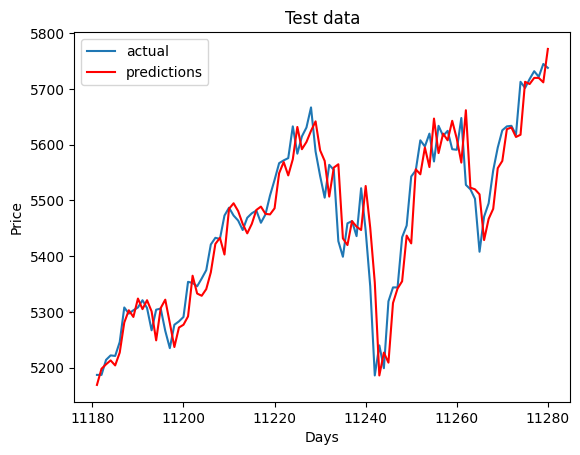

[*********************100%***********************]  1 of 1 completed


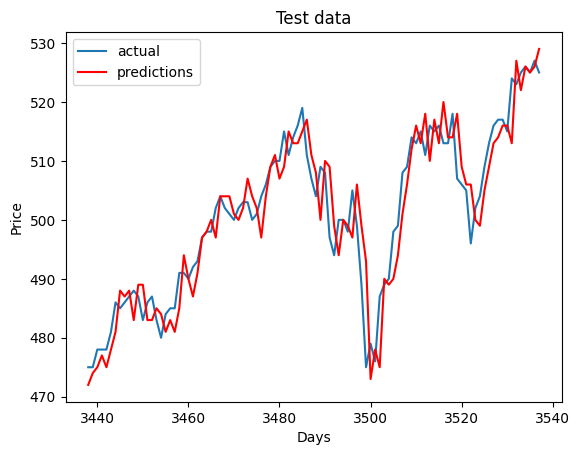

[*********************100%***********************]  1 of 1 completed


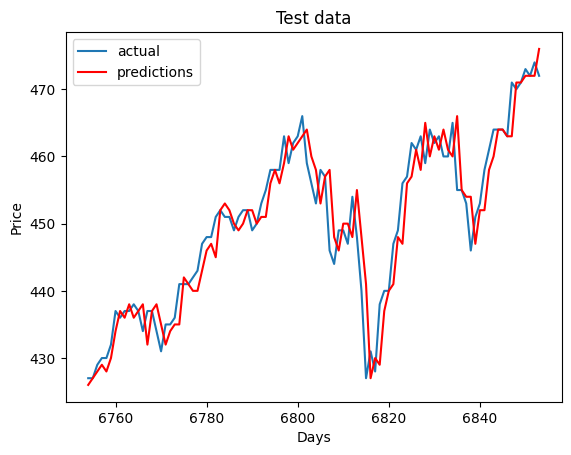

[*********************100%***********************]  1 of 1 completed


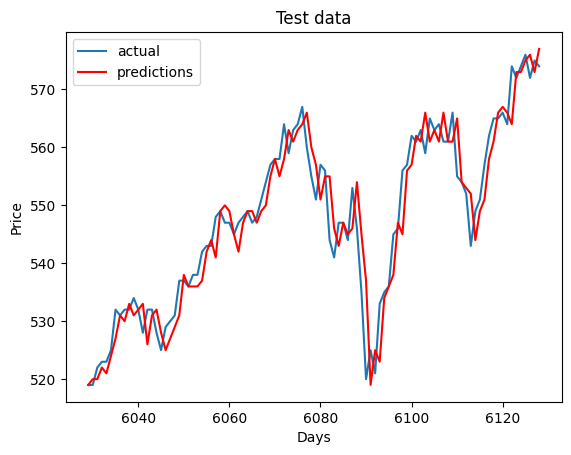

[*********************100%***********************]  1 of 1 completed


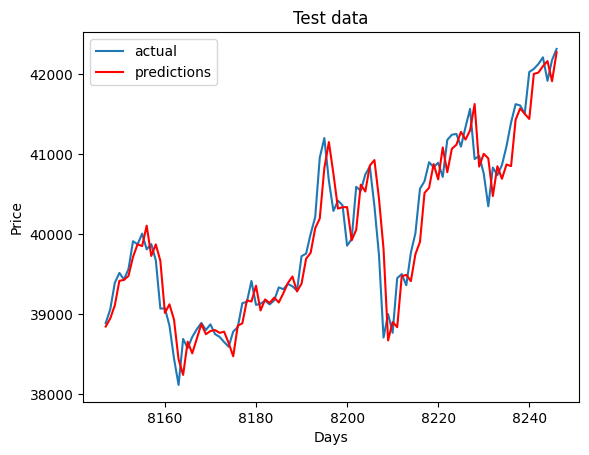

[*********************100%***********************]  1 of 1 completed


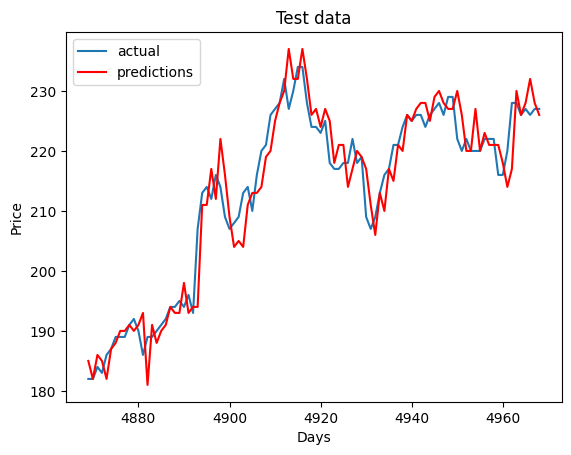

In [15]:
stock = [['^GSPC', '1980-01-01', '2024-10-01'],
        ['VOO', '1980-01-01', '2024-10-01'],
        ['VIIIX', '1980-01-01', '2024-10-01'],
        ['IVV', '1980-01-01', '2024-10-01'],
        ['^DJI', '1980-01-01', '2024-10-01'],
        ['AAPL', '2005-01-01', '2024-10-01']]
for i in stock:
    test_stock(i)

## Remarks

This is about as close as a regression model will get to representing a wave function. We will begin to use other models to output probability distribution vectors as predictions. These vectors will represent the wave function of aquantum system.